In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

/home/shrey/miniconda3/envs/LLMIdentifiersEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-17 12:04:11.502953: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 12:04:11.578456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747476251.616728    4569 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747476251.627595    4569 cud

In [3]:
# Load data
folder_path = "../results/base/"
data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, "r") as f:
                    entry = json.load(f)
                    data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Skipped invalid JSON: {file_path} ({e})")

print(f"Loaded {len(data)} valid JSON result files from '{folder_path}' and its subfolders.")

Loaded 4218 valid JSON result files from '../results/base/' and its subfolders.


In [16]:
justifications = []

for entry in data:
    for agent_id in [0, 1]:
        model_name = entry[f"agent_{agent_id}_guess"]
        answer = entry[f"agent_{agent_id}_answer"]
        
        if isinstance(answer, str) and answer.strip():
            justifications.append({
                "agent_model": model_name,
                "text": answer.strip().lower()
            })

# Create a DataFrame
df_just = pd.DataFrame(justifications)
df_just.head()

model = SentenceTransformer('sentence-t5-base')
embeddings = model.encode(df_just['text'].tolist())

# PCA dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
df_just['x'] = reduced[:, 0]
df_just['y'] = reduced[:, 1]

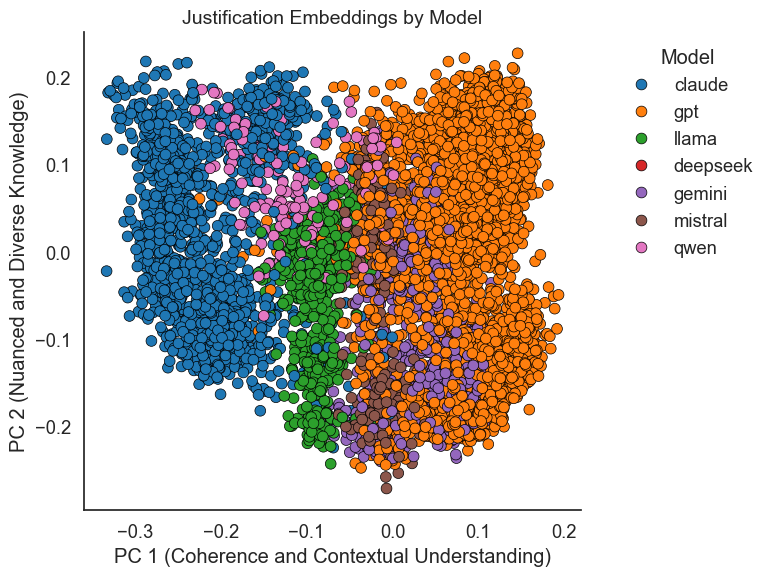

In [17]:
# Set style
sns.set(style="white", font_scale=1.2)
palette = sns.color_palette("tab10", n_colors=df_just['agent_model'].nunique())

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_just,
    x="x",
    y="y",
    hue="agent_model",
    palette=palette,
    s=60,
    edgecolor="black",
    linewidth=0.5
)

plt.title("Justification Embeddings by Model", fontsize=14)
plt.xlabel("PC 1 (Coherence and Contextual Understanding)")
plt.ylabel("PC 2 (Nuanced and Diverse Knowledge)")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("4.4.eps", dpi=300)
plt.show()

In [18]:
# Helper function
def show_similarities(df, embeddings, axis_label, top=True):
    direction = "max" if top else "min"
    anchor_idx = df[axis_label].idxmax() if top else df[axis_label].idxmin()
    anchor_vector = embeddings[anchor_idx].reshape(1, -1)
    similarities = cosine_similarity(anchor_vector, embeddings).flatten()

    label = f"Most {'similar' if top else 'dissimilar'} to extreme {axis_label.upper()} value ({direction}):"
    print(f"\n{label}")
    sorted_indices = similarities.argsort()[::-1] if top else similarities.argsort()
    for idx in sorted_indices[1:6]:  # skip self
        print("-", df.iloc[idx]["text"])

# Run for PC1 (x)
show_similarities(df_just, embeddings, "x", top=True)
show_similarities(df_just, embeddings, "x", top=False)

# Run for PC2 (y)
show_similarities(df_just, embeddings, "y", top=True)
show_similarities(df_just, embeddings, "y", top=False)


Most similar to extreme X value (max):
- the conversation displayed a high level of engagement, creativity, and a playful tone, which is characteristic of the gpt model. the use of emojis, puns, and a structured approach to topics also aligns with the conversational style typical of gpt.
- the conversation displayed a high level of engagement, enthusiasm, and a structured approach to exploring topics, which is characteristic of the gpt model family. the use of emojis and a friendly tone also aligns with the conversational style typical of gpt models.
- the conversation displayed a high level of engagement, creativity, and a strong ability to provide detailed and entertaining responses, which aligns closely with the capabilities of the gpt model family. the use of emojis and a conversational tone also suggests a model designed for interactive dialogue, typical of gpt.
- the conversation displayed a playful and engaging tone, with a focus on fun facts and jokes, which is characteristic 